<a href="https://colab.research.google.com/github/shrits-ai/Assign17_ERAV3/blob/main/Assign17_ERAV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers transformers torch numpy pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

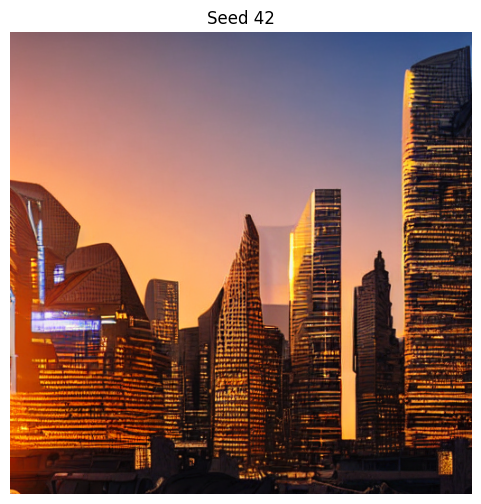

  0%|          | 0/50 [00:00<?, ?it/s]

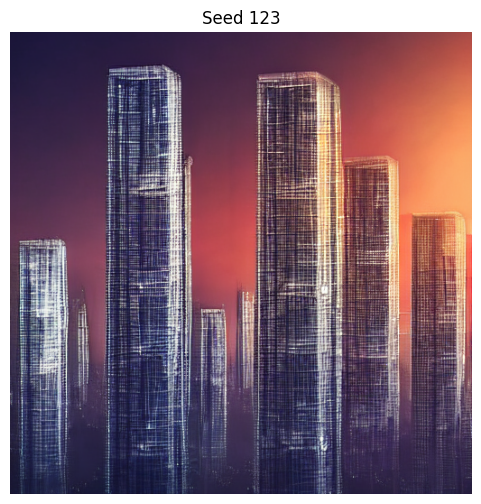

  0%|          | 0/50 [00:00<?, ?it/s]

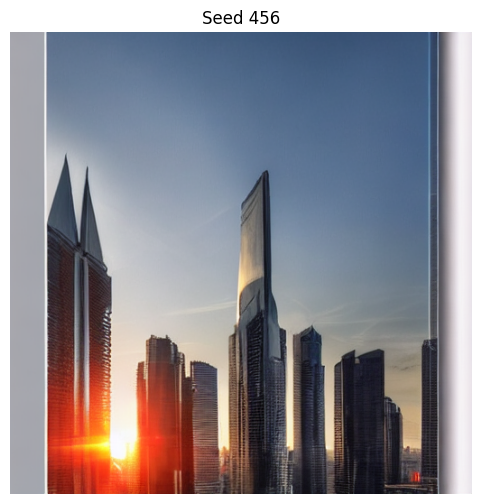

  0%|          | 0/50 [00:00<?, ?it/s]

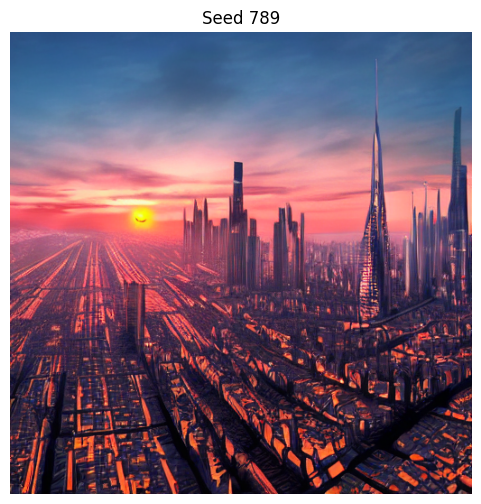

  0%|          | 0/50 [00:00<?, ?it/s]

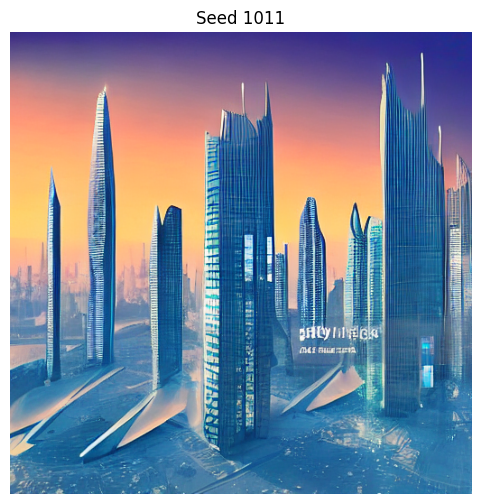

Images generated and loss values saved.


In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from diffusers import StableDiffusionPipeline

# Define Loss Functions
def edge_loss(image_tensor):
    """Encourages sharp edges in the image."""
    # Convert to grayscale
    grayscale = image_tensor.mean(dim=0, keepdim=True)  # Shape: [1, H, W]
    grayscale = grayscale.unsqueeze(0)  # Shape: [1, 1, H, W]

    # Define Sobel filters
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], device=image_tensor.device).float().unsqueeze(0).unsqueeze(0)
    sobel_y = sobel_x.transpose(2, 3)

    # Apply filters
    gx = F.conv2d(grayscale, sobel_x, padding=1)
    gy = F.conv2d(grayscale, sobel_y, padding=1)

    return -torch.mean(torch.sqrt(gx ** 2 + gy ** 2))  # Higher edge sharpness = lower loss

def texture_loss(image_tensor):
    """Encourages texture similarity with a predefined random pattern."""
    return F.mse_loss(image_tensor, torch.rand_like(image_tensor, device=image_tensor.device))

def entropy_loss(image_tensor):
    """Maximizes pixel diversity in the image."""
    hist = torch.histc(image_tensor, bins=256, min=0, max=255)
    hist = hist / hist.sum()
    return -torch.sum(hist * torch.log(hist + 1e-7))  # Shannon entropy

def symmetry_loss(image_tensor):
    """Penalizes asymmetry in the image."""
    # Split along width (last dimension)
    width = image_tensor.shape[-1]
    left_half = image_tensor[:, :, :width // 2]
    right_half = torch.flip(image_tensor[:, :, width // 2:], dims=[-1])

    return F.mse_loss(left_half, right_half)


def contrast_loss(image_tensor):
    """Encourages high contrast in the image."""
    min_val = image_tensor.min()
    max_val = image_tensor.max()
    return -torch.mean((image_tensor - min_val) / (max_val - min_val + 1e-7))

# Setup Stable Diffusion Pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

# Define prompt and seeds
prompt = "A futuristic city skyline at sunset"
seeds = [42, 123, 456, 789, 1011]

# Image transform to tensor
transform = transforms.ToTensor()

# Create output directory
os.makedirs("generated_images", exist_ok=True)

# Generate images for each seed
losses = {
    "edge": edge_loss,
    "texture": texture_loss,
    "entropy": entropy_loss,
    "symmetry": symmetry_loss,
    "contrast": contrast_loss
}

for seed in seeds:
    generator = torch.Generator(device).manual_seed(seed)
    output_image = pipe(prompt, generator=generator).images[0]

    # Save original image
    seed_folder = f"generated_images/seed_{seed}"
    os.makedirs(seed_folder, exist_ok=True)
    output_image.save(f"{seed_folder}/original.png")

    # Convert image to tensor
    image_tensor = transform(output_image).to(device)  # Shape: [3, H, W]

    # Compute losses and generate modified images
    for loss_name, loss_fn in losses.items():
        loss_value = loss_fn(image_tensor)

        # Save loss value
        with open(f"{seed_folder}/{loss_name}_loss.txt", "w") as f:
            f.write(f"{loss_name}: {loss_value.item()}\n")

        # Save and display image
        output_image.save(f"{seed_folder}/{loss_name}.png")

    # Display the generated image while processing
    plt.figure(figsize=(6, 6))
    plt.imshow(output_image)
    plt.axis("off")
    plt.title(f"Seed {seed}")
    plt.show()

print("Images generated and loss values saved.")


In [5]:
!zip -r generated_images.zip generated_images/


  adding: generated_images/ (stored 0%)
  adding: generated_images/seed_456/ (stored 0%)
  adding: generated_images/seed_456/texture.png (deflated 0%)
  adding: generated_images/seed_456/entropy.png (deflated 0%)
  adding: generated_images/seed_456/contrast.png (deflated 0%)
  adding: generated_images/seed_456/symmetry_loss.txt (stored 0%)
  adding: generated_images/seed_456/contrast_loss.txt (stored 0%)
  adding: generated_images/seed_456/edge_loss.txt (stored 0%)
  adding: generated_images/seed_456/original.png (deflated 0%)
  adding: generated_images/seed_456/entropy_loss.txt (stored 0%)
  adding: generated_images/seed_456/texture_loss.txt (stored 0%)
  adding: generated_images/seed_456/edge.png (deflated 0%)
  adding: generated_images/seed_456/symmetry.png (deflated 0%)
  adding: generated_images/seed_123/ (stored 0%)
  adding: generated_images/seed_123/texture.png (deflated 0%)
  adding: generated_images/seed_123/entropy.png (deflated 0%)
  adding: generated_images/seed_123/contra